In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Image Style Transfer/Monalisa1')

Mounted at /content/drive


In [ ]:
pip install opencv-python-headless numpy tensorflow

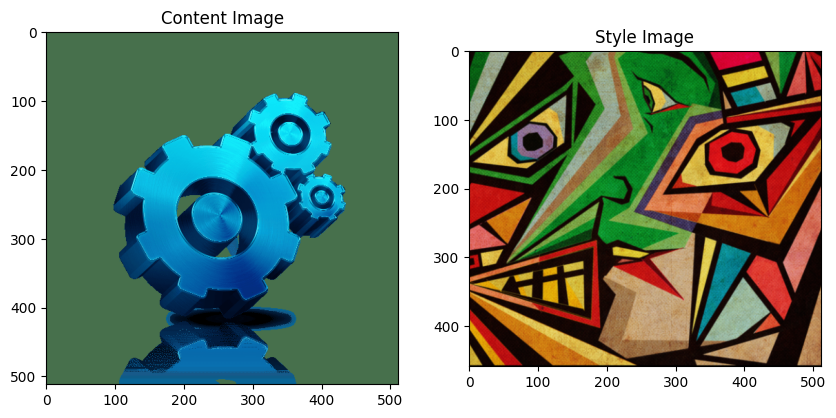

80134624/80134624 [==============================] - 0s 0us/step
....................................................................................................

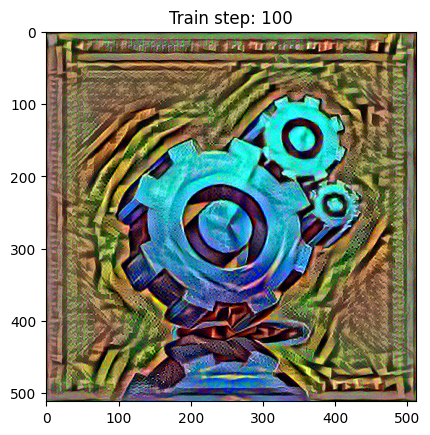

....................................................................................................

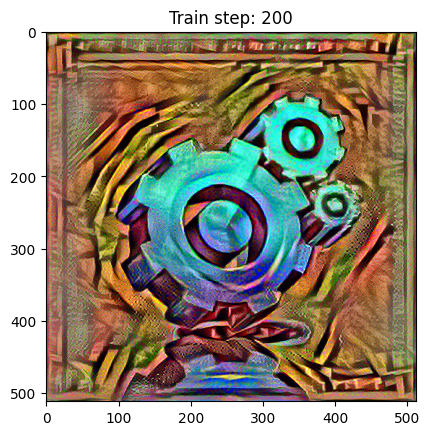

....................................................................................................

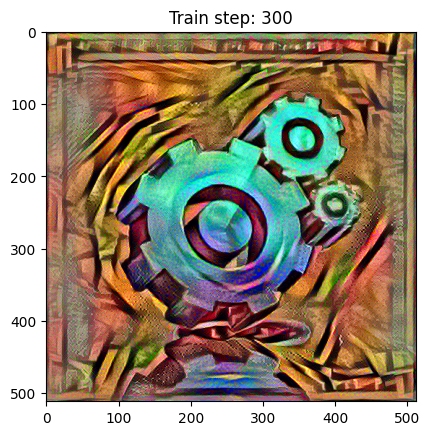

....................................................................................................

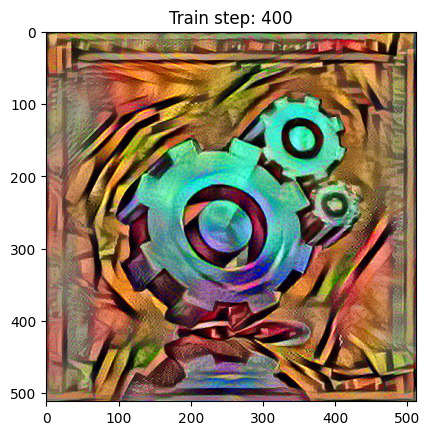

....................................................................................................

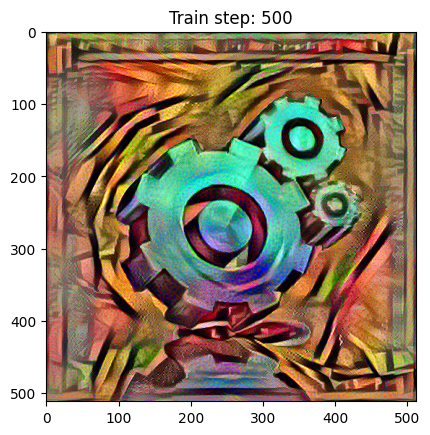

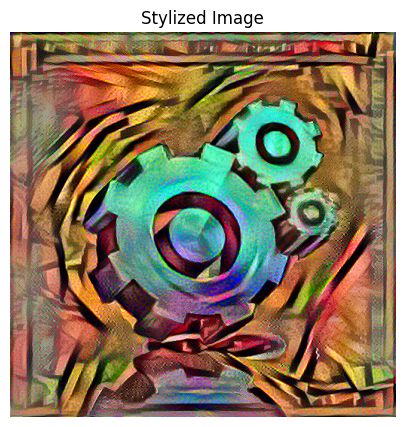

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub

# Function to load and preprocess images
def load_image(image_path):
    max_dim = 512
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

# Function to display images
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

# Content and style images
content_path = 'settings.jpg'
style_path = 'Style_Image1.jpg'

content_image = load_image(content_path)
style_image = load_image(style_path)

# Display content and style images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')
plt.show()

# Load pre-trained VGG19 model
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# Content and style layers
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Feature extraction model
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model(inputs=vgg.input, outputs=outputs)
    return model

# Gram matrix calculation
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

# Style content model
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (
            outputs[:self.num_style_layers],
            outputs[self.num_style_layers:]
        )

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

# Calculate style and content features
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Define optimization function
style_weight = 1e-2
content_weight = 1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
        for name in style_outputs.keys()
    ])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
        for name in content_outputs.keys()
    ])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

# Define gradient descent
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

# Stylize the content image
image = tf.Variable(content_image)

epochs = 5
steps_per_epoch = 100
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

# Display final stylized image
plt.figure(figsize=(10, 5))
plt.axis("off")
imshow(image.read_value())
plt.savefig('Stylized_Image_settings.jpg')
plt.title('Stylized Image')
plt.show()
